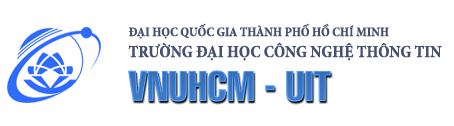



**ĐỒ ÁN CUỐI KỲ MÔN MÁY HỌC - CS114.N21**

---



**BÀI TOÁN: DỰ ĐOÁN GIỚI TÍNH CỦA MỘT NGƯỜI DỰA VÀO HỌ TÊN NGƯỜI ĐÓ**

`Lớp: CS114.N21`

`GV hướng dẫn: TS. Lê Đình Duy, ThS. Phạm Nguyễn Trường An	`

`Thành viên nhóm HKV:`



`1.   Nguyễn Trung Kiên - 21521024`

`2.   Nguyễn Sĩ Hùng - 21522119`

`3.   Phạm Quốc Việt - 21522792`


`Tp. HCM, tháng 7 năm 2023`

**`Mục lục`**

`I. Tổng quan đồ án`

`II. Xây dựng bộ dữ liệu`

`III. Áp dụng các mô hình máy học và trích chọn đặc trưng`

`IV. Kết luận`



##**`I. Tổng quan đồ án`**

###`1.1. Mô tả bài toán`

`Đề tài dự đoán giới tính một người dựa vào họ tên là đề tài hướng đến việc sử dụng họ và tên của một người để có thể phân loại người đó là nam hay nữ. Trong Machine Learning, đây là dạng bài toán có tên gọi Binary Classification, trong đó bài toán chỉ có hai classes, cũng là hai giới tính cần được phân loại.`

###**`1.2. Input và output của bài toán`**

`- Input: Dataset bao gồm họ và tên và giới tính tương ứng`

`- Output: Họ và tên người cần dự đoán và giới tính được dự đoán của người đó`

###**`1.3. Các thuật toán máy học mà đồ án sử dụng`**

`Trong bài báo cáo, nhóm sẽ sử dụng 4 mô hình classification, đó là: Logistics Regression, SVM, Gaussian Naive Bayes và Decision Tree. Sau khi qua các bước xử lý dữ liệu và trích chọn đặc trưng, data được xử lý sẽ đưa vào các mô hình classification và sau cùng đánh giá từng mô hình bằng confusion matrix và giá trị của các metrics: accuracy, precision, recall và f1-score.`

###**`1.4. Các tiêu chí về một mô hình được đánh giá tốt`**

`2 tiêu chí mà nhóm sử dụng để đánh giá một mô hình có thể xem là tốt đó là:`

`- f1-score cao: f1- score là giá trị trung bình điều hòa của precision và recall. Hiểu một cách đơn giản, f1-score cân bằng hai giá trị precision và recall. Đôi khi trong một số trường hợp, tập dữ liệu quá nghiêng về trường hợp positive, giá trị precision sẽ cao nhưng recall thấp, và ngược lại. Hiện tượng này thường được đề cập với tên gọi precision-recall trade-off. Do đó, để tránh việc này, f1-score phải cao thì mới tương ứng với precision cao và recall cao. Nhóm hi vọng f1-score của nhóm đạt trên 90%.`

`- Confusion matrix: Mô hình tốt là khi confusion matrix có giá trị lớn (đậm đặc về màu sắc) trên đường chéo chính của nó, cho thấy các điểm dữ liệu đã được phân loại đúng là lớn.`  


##**`II. Xây dựng bộ dữ liệu`**

`Trước tiên, nhóm sẽ khai báo các package cần thiết sẽ sử dụng cho bài toán như sau: `



In [ ]:
!pip install transformers
import pandas as pd
import torch
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup, logging
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

`Đọc file json lấy từ dataset của nhóm trên github`

In [ ]:
data = pd.read_json("https://raw.githubusercontent.com/kiendoo4/final-project/main/dataset/Final_dataset.json")
print(data)

                full_name  gender
0           Ngô Xuân Tùng       1
1       Bùi Dương Thảo Vy       0
2             Lưu Thế Huy       1
3          Nguyễn Thị Vân       0
4         Dương Minh Long       1
...                   ...     ...
28796    Huỳnh Thu Phương       0
28797      Mai Nguyệt Lan       0
28798       Hà Thanh Ngân       0
28799  Phan Thị Tuyết Nhi       0
28800    Vũ Hoàng Thúy Vy       0

[28801 rows x 2 columns]


`Mô tả về bộ dataset`

`- Số lượng nam, nữ giới và còn lại trong bộ data lần lượt là: 16613, 12188 và 0, số lượng nam và nữ giới trong dataset gần bằng nhau để phần nào tránh được tình trạng information bias`

In [ ]:
#Number of males, females and others in data, and the length of data
male = 0
female = 0
other = 0
for line in data["gender"]:
  if line == 1:
    male += 1
  elif line == 0:
    female += 1
  else:
    print(line)
    other += 1
print("Number of males, females and others in data: %s, %s, %s" % (male, female, other))
print("Length of data: %s" % len(data["gender"]))

Number of males, females and others in data: 16613, 12188, 0
Length of data: 28801


`Số lượng họ và tên không trùng trong dataset được lọc ra là 19431. Nhóm lưu các full_name vào kiểu dữ liệu set để không bị trùng lặp. Việc lọc bỏ các dữ liệu trùng lặp cũng sẽ tránh việc information bias. Sau cùng, ta được data chứa một bộ các họ và tên không có bất kỳ bộ đôi họ và tên nào trùng lặp với nhau`

In [ ]:
name_counts = data['full_name'].value_counts()
unique_names = name_counts[name_counts == 1].index
data = data[data['full_name'].isin(unique_names)]
print(data)

                  full_name  gender
1         Bùi Dương Thảo Vy       0
2               Lưu Thế Huy       1
4           Dương Minh Long       1
5            Trần Mai Khanh       0
6      Nguyễn Thị Hồng Diệp       0
...                     ...     ...
28794    Phạm Đoàn Bảo Châu       0
28796      Huỳnh Thu Phương       0
28797        Mai Nguyệt Lan       0
28798         Hà Thanh Ngân       0
28800      Vũ Hoàng Thúy Vy       0

[19431 rows x 2 columns]


`Tách data ra làm 2 phần: X tương ứng với họ và tên và y tương ứng với giá trị đã quy định cho giới tính, 0 là nữ giới, và 1 ứng với nam giới`

In [ ]:
X = data["full_name"]
y = data["gender"]

##**`III. Áp dụng các mô hình máy học và trích chọn đặc trưng`**

`Trước tiên, ta chia dữ liệu để xử lý các bước kế tiếp, tỉ lệ 80/20 tương ứng với data để train và data để test`

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


####`3.1. Áp dụng PhoBERT`

In [ ]:
phobert = AutoModel.from_pretrained("vinai/phobert-base-v2")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
X_train_encoded = tokenizer.batch_encode_plus(
    X_train.tolist(),
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)
X_test_encoded = tokenizer.batch_encode_plus(
    X_test.tolist(),
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)
print(X_train_encoded)

Some weights of the model checkpoint at vinai/phobert-base-v2 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'input_ids': tensor([[    0,  3212,  2521,  ...,     1,     1,     1],
        [    0,  3751,  8224,  ...,     1,     1,     1],
        [    0, 34811,  1962,  ...,     1,     1,     1],
        ...,
        [    0,  1955,  1612,  ...,     1,     1,     1],
        [    0, 34811,  1858,  ...,     1,     1,     1],
        [    0,  4267,  2965,  ...,     1,     1,     1]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [ ]:
# Pass the encoded inputs through the PhoBERT model
with torch.no_grad():
    X_train_embeddings = phobert(
        input_ids=X_train_encoded['input_ids'],
        attention_mask=X_train_encoded['attention_mask']
    ).pooler_output
    X_test_embeddings = phobert(
        input_ids=X_test_encoded['input_ids'],
        attention_mask=X_test_encoded['attention_mask']
    ).pooler_output

`Sau khi đưa qua mô hình PhoBERT, data có dạng text mà ta có lúc đầu đã được convert về dạng numpy array, lúc này là đủ để sử dụng mô hình máy học`

In [ ]:
X_train_embeddings = X_train_embeddings.cpu().numpy()
X_test_embeddings = X_test_embeddings.cpu().numpy()
print(type(X_train_embeddings))

<class 'numpy.ndarray'>


`Sử dụng Logistic Regression`

In [ ]:
# 1. Train a logistic regression model
lr_model = LogisticRegression(max_iter=10000000)
lr_model.fit(X_train_embeddings, y_train)

# Predict on the test set
y_pred = lr_model.predict(X_test_embeddings)

# Evaluate the model

print(classification_report(y_test, y_pred))
print("F1-score of using logistic regression:", f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.92      1655
           1       0.92      0.97      0.94      2232

    accuracy                           0.93      3887
   macro avg       0.93      0.92      0.93      3887
weighted avg       0.93      0.93      0.93      3887

F1-score of using logistic regression: 0.9410222804718217


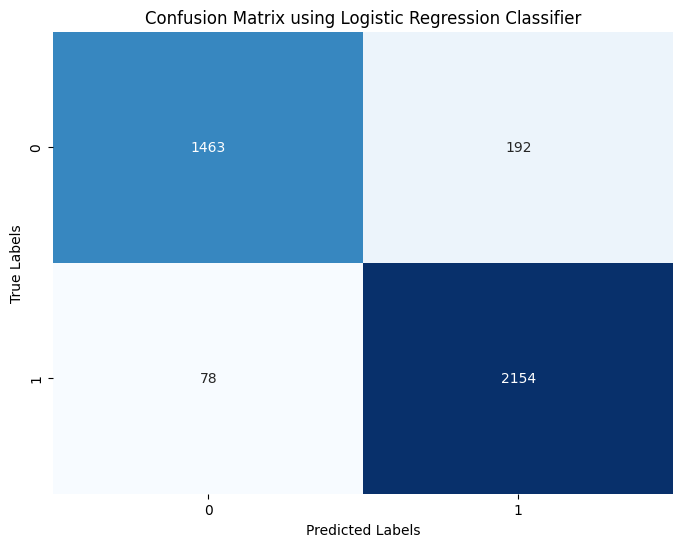

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Logistic Regression Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Sử dụng SVM`

In [ ]:
#2. Train a SVM classifier
svm_model = SVC()
svm_model.fit(X_train_embeddings, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("F1-score of using SVM model:", f1_score(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1655
           1       0.91      0.97      0.94      2232

    accuracy                           0.93      3887
   macro avg       0.94      0.93      0.93      3887
weighted avg       0.93      0.93      0.93      3887

F1-score of using SVM model: 0.9431670281995661


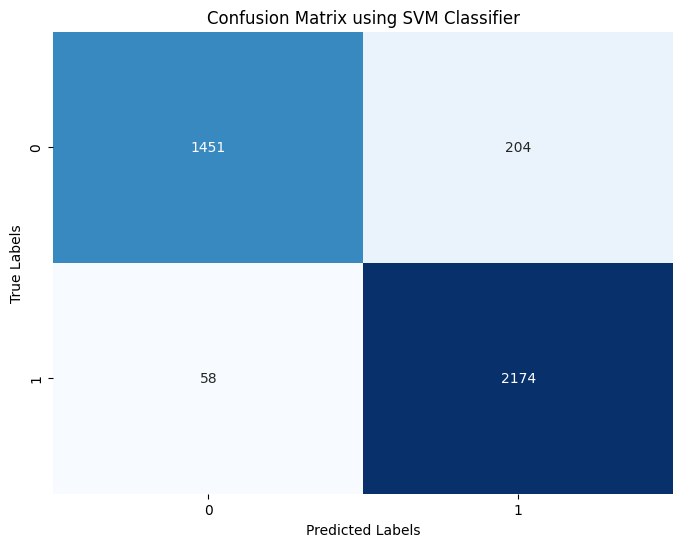

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using SVM Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Sử dụng Gaussian Naive Bayes`

In [ ]:
# 3. Train a Gaussian Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train_embeddings, y_train)
# Predict on the test set
y_pred = nb_model.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("F1-score of using GaussianNB model:", f1_score(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.95      0.81      0.87      1655
           1       0.87      0.97      0.92      2232

    accuracy                           0.90      3887
   macro avg       0.91      0.89      0.90      3887
weighted avg       0.91      0.90      0.90      3887

F1-score of using GaussianNB model: 0.9180258419826308


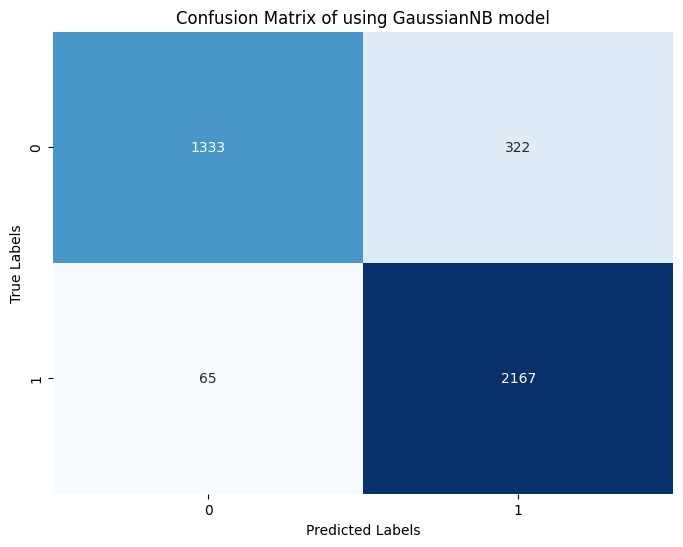

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using GaussianNB model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Sử dụng Decision Tree`

In [ ]:
#4. Train a Decision Tree Classifier model
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_embeddings, y_train)

# Predict on the test set
y_pred = tree_model.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of using DecisionTreeClassifier:", accuracy)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)


              precision    recall  f1-score   support

           0       0.77      0.80      0.79      1655
           1       0.85      0.83      0.84      2232

    accuracy                           0.81      3887
   macro avg       0.81      0.81      0.81      3887
weighted avg       0.82      0.81      0.82      3887

Accuracy of using DecisionTreeClassifier: 0.8147671726267044


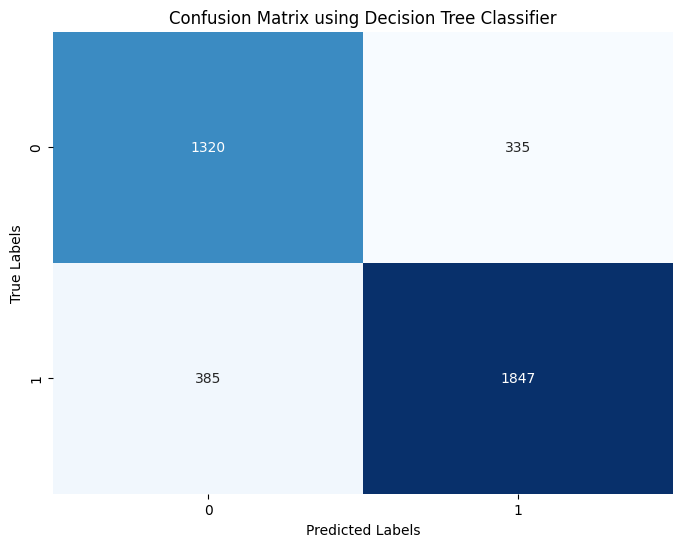

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Decision Tree Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Hàm separate_full_name nhằm trả về tên đệm và tên của một người. Trường hợp không có tên đệm thì ta trả về tên đệm là một chuỗi rỗng`

In [ ]:
#Split function to take away the surname
def separate_full_name(full_name):
    fname = full_name.split()
    name = ""
    middle_name = ""
    surname = ""
    if len(fname) > 2:
      name = fname[len(fname) - 1]
      surname = fname[len(fname) - 3]
      middle_name = fname[len(fname) - 2]
    elif len(fname) == 2:
      name = fname[1]
      middle_name = ""
      surname = ""
    return middle_name, name

`Tách họ ra khỏi họ và tên trong dataset, ta được kết quả như sau`

In [ ]:
X_erase_surname = []
for line in data['full_name']:
  fname = line
  middle_name, name = separate_full_name(fname)
  if middle_name != "":
    X_erase_surname.append(middle_name + " " + name)
  else:
    X_erase_surname.append(name)
print(X_erase_surname)

['Thảo Vy', 'Thế Huy', 'Minh Long', 'Mai Khanh', 'Hồng Diệp', 'Ngọc Thái', 'Tường Vy', 'Trúc Quỳnh', 'Minh Đức', 'Ngọc Tấn', 'Minh Hiếu', 'Kim Yến', 'Thị Thanh', 'Lệ Chi', 'Tấn Nghĩa', 'Kim Dân', 'Minh Chương', 'Thị Việt', 'Xuân Việt', 'Nhật Huy', 'Đức Trung', 'Tiến Đạt', 'Ngọc Giàu', 'Mỹ Linh', 'Phúc', 'Yến Ngọc', 'Thị Trang', 'Hiếu Nhơn', 'Anh Hiếu', 'Thị Trang', 'Anh Duy', 'Thanh Ngôn', 'Thiện Huân', 'Đình Đức', 'Diệu Hiền', 'Đại Nghĩa', 'Thu Thủy', 'Khảo Xương', 'Anh Tú', 'Sec Váy', 'Huỳnh Duyên', 'Mỹ Uyên', 'Tiến Nam', 'Thanh Thanh', 'Thiên Phước', 'Xuân Tùng', 'Huy Phong', 'Như Minh', 'Thanh Quí', 'Quang Hào', 'Thành Đạt', 'Bích Trúc', 'Trung Dũng', 'Ngọc Công', 'Thị Triều', 'Mỹ Phương', 'Hoàng Anh', 'Thảo Nguyên', 'Huỳnh Như', 'Tuấn Sang', 'Thu Huyền', 'Kim Ngân', 'Hải Đăng', 'Trọng Khánh', 'Thanh Toàn', 'Nhựt Tân', 'Ái Liên', 'Kiều Diễm', 'Minh Thiên', 'Hồng Phi', 'Minh Thoại', 'Hải Thắng', 'Công Danh', 'Mạnh Hùng', 'Ngọc Thuận', 'Song Luân', 'Xuân Tuyền', 'Quý Tài', 'Khánh Ngọ

`Một lần nữa, áp dụng các mô hình máy học sau đó đánh giá`

In [ ]:
phobert = AutoModel.from_pretrained("vinai/phobert-base-v2")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
X_train, X_test, y_train, y_test = train_test_split(X_erase_surname, y, test_size=0.2, random_state=42)
X_train_encoded = tokenizer.batch_encode_plus(
    X_train,
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)
X_test_encoded = tokenizer.batch_encode_plus(
    X_test,
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)
print(X_train_encoded)

Some weights of the model checkpoint at vinai/phobert-base-v2 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens

{'input_ids': tensor([[    0,  2521, 13201,  ...,     1,     1,     1],
        [    0,  3019,  8517,  ...,     1,     1,     1],
        [    0,  2883,  6984,  ...,     1,     1,     1],
        ...,
        [    0,  1612, 23131,  ...,     1,     1,     1],
        [    0,  6739,   590,  ...,     1,     1,     1],
        [    0,  1827, 15512,  ...,     1,     1,     1]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [ ]:
# Pass the encoded inputs through the PhoBERT model
with torch.no_grad():
    X_train_embeddings = phobert(
        input_ids=X_train_encoded['input_ids'],
        attention_mask=X_train_encoded['attention_mask']
    ).pooler_output
    X_test_embeddings = phobert(
        input_ids=X_test_encoded['input_ids'],
        attention_mask=X_test_encoded['attention_mask']
    ).pooler_output

In [ ]:
X_train_embeddings = X_train_embeddings.cpu().numpy()
X_test_embeddings = X_test_embeddings.cpu().numpy()
print(type(X_train_embeddings))

<class 'numpy.ndarray'>


In [ ]:
# 1. Train a logistic regression model
lr_model = LogisticRegression(max_iter=10000000)
lr_model.fit(X_train_embeddings, y_train)

# Predict on the test set
y_pred = lr_model.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("F1-score of using logistic regression:", f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.86      0.89      1655
           1       0.90      0.94      0.92      2232

    accuracy                           0.91      3887
   macro avg       0.91      0.90      0.90      3887
weighted avg       0.91      0.91      0.91      3887

F1-score of using logistic regression: 0.9195604395604396


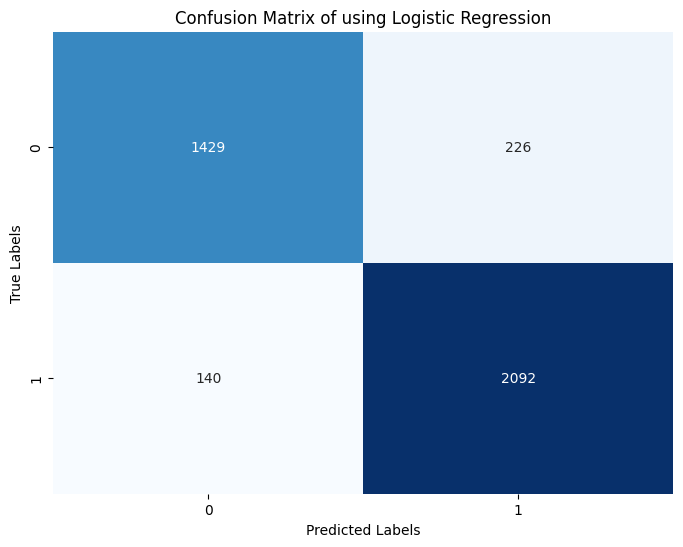

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
#2. Train a SVM classifier
svm_model = SVC()
svm_model.fit(X_train_embeddings, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("F1-score of using SVM model:", f1_score(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1655
           1       0.90      0.95      0.93      2232

    accuracy                           0.91      3887
   macro avg       0.92      0.91      0.91      3887
weighted avg       0.91      0.91      0.91      3887

F1-score of using SVM model: 0.9261276966659403


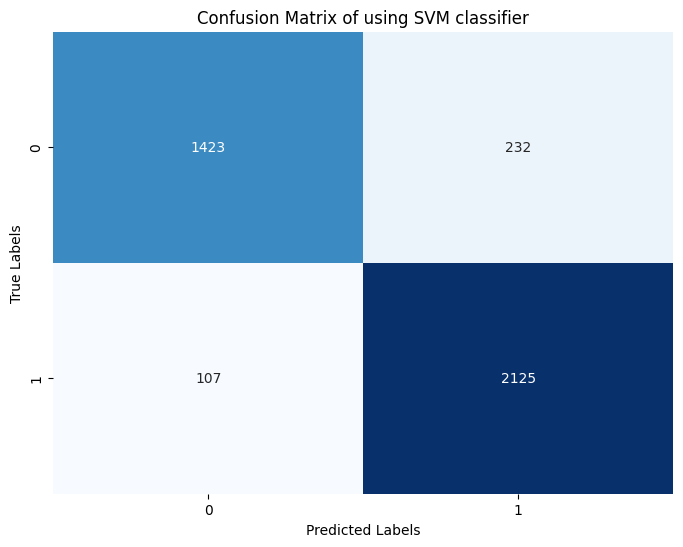

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using SVM classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
# 3. Train a Gaussian Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train_embeddings, y_train)
# Predict on the test set
y_pred = nb_model.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("F1-score of using GaussianNB model:", f1_score(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.95      0.81      0.87      1655
           1       0.87      0.97      0.92      2232

    accuracy                           0.90      3887
   macro avg       0.91      0.89      0.90      3887
weighted avg       0.91      0.90      0.90      3887

F1-score of using GaussianNB model: 0.9180467091295117


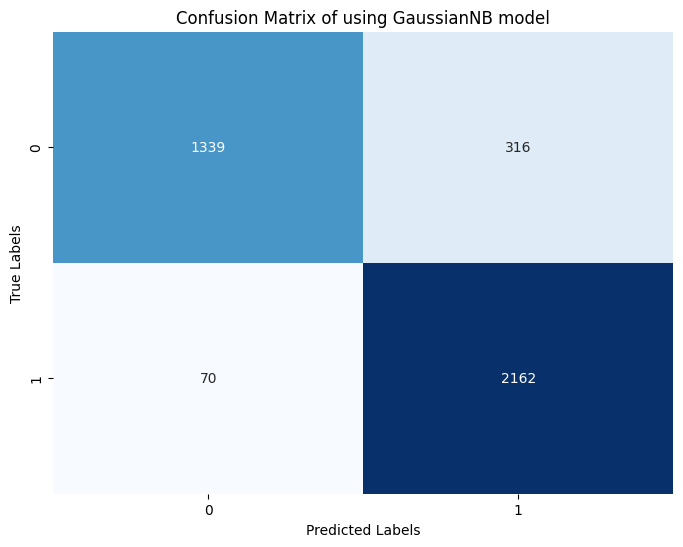

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using GaussianNB model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
#4. Train a Decision Tree Classifier model
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_embeddings, y_train)

# Predict on the test set
y_pred = tree_model.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of using DecisionTreeClassifier:", accuracy)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)


              precision    recall  f1-score   support

           0       0.78      0.79      0.79      1655
           1       0.84      0.84      0.84      2232

    accuracy                           0.82      3887
   macro avg       0.81      0.81      0.81      3887
weighted avg       0.82      0.82      0.82      3887

Accuracy of using DecisionTreeClassifier: 0.8175971186004631


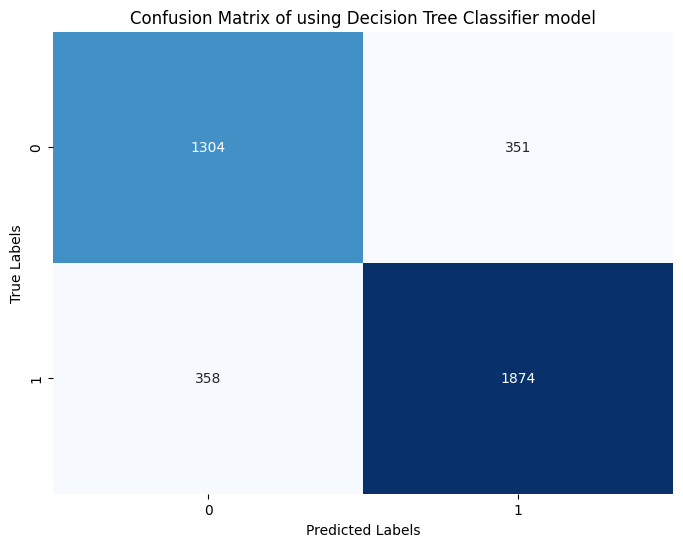

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Decision Tree Classifier model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

####`3.2. Bag of n-grams`

`Bag of n-grams là một mô hình tương tự như Bag of Words, chỉ khác một điều là mô hình này là một tập hợp các cụm phần tử có chuỗi n phần tử liền kề với nhau từ một văn bản cho trước. Nếu n = 1 (unigram) thì ta có thể xem đây là bag of words. Các phần tử có thể là các từ, chữ cái, âm tiết,...`

`Ví dụ: ta có một câu như sau: "Xin chào thế giới."`

`Với unigram (n = 1): "Xin", "chào", "thế", "giới"`

`Với bigram (n = 2): "Xin chào", "chào thế", "thế giới"`
`Với trigram (n = 3): "Xin chào thế", "chào thế giới"`



`Trong thư viện sklearn.feature_extraction.text có một hàm là CountVectorizer(), ta dùng hàm này để áp dụng mô hình Bag of n-grams cho đồ án.`



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

`Ta dùng hàm CountVectorizer() với ngram_range=(2, 3)) - n thuộc khoảng từ 2 -> 3`

In [ ]:
cv = CountVectorizer(ngram_range=(2, 3))

`Biến đổi dữ liệu văn bản thành ma trận đếm`

In [ ]:
X_convert = cv.fit_transform(np.array(X))

`In ma trận đếm và các cụm từ tương ứng`

In [ ]:
print(X_convert.toarray())
cv.get_feature_names_out()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


array(['ahmad qalal', 'ai nhi', 'ai quốc', ..., 'ừng chánh cóng',
       'ừng hoài', 'ừng hoài phương'], dtype=object)

`Chia data thành 80% bộ train và 20% bộ test`

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_convert, y, test_size=0.2, random_state=42)

`Sử dụng mô hình SVM để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

              precision    recall  f1-score   support

           0       0.97      0.74      0.84      1655
           1       0.84      0.98      0.90      2232

    accuracy                           0.88      3887
   macro avg       0.90      0.86      0.87      3887
weighted avg       0.89      0.88      0.88      3887

F1-score of using SVM: 0.904408735063865


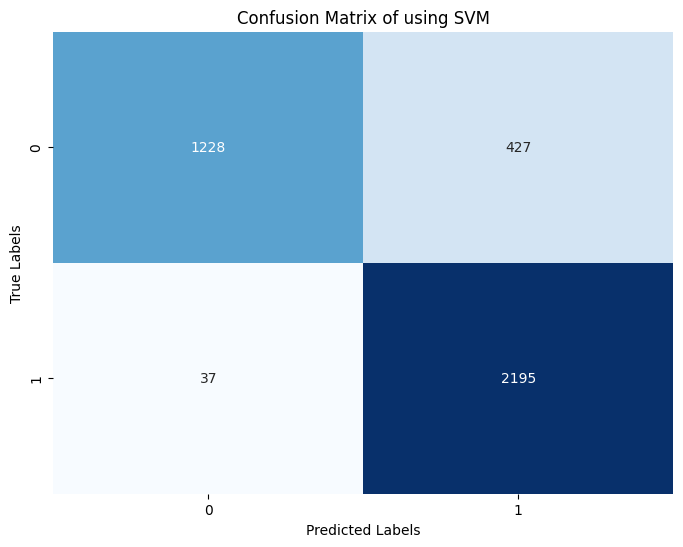

In [ ]:
# Huấn luyện mô hình SVM
clf = SVC()
clf.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using SVM:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Sử dụng mô hình Logistic Regression để huấn luyện mô hình và đánh giá độ chính xác của mô hình`



              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1655
           1       0.84      0.99      0.90      2232

    accuracy                           0.88      3887
   macro avg       0.91      0.86      0.87      3887
weighted avg       0.90      0.88      0.88      3887

F1-score of using Logistic Regression: 0.9048304213771841


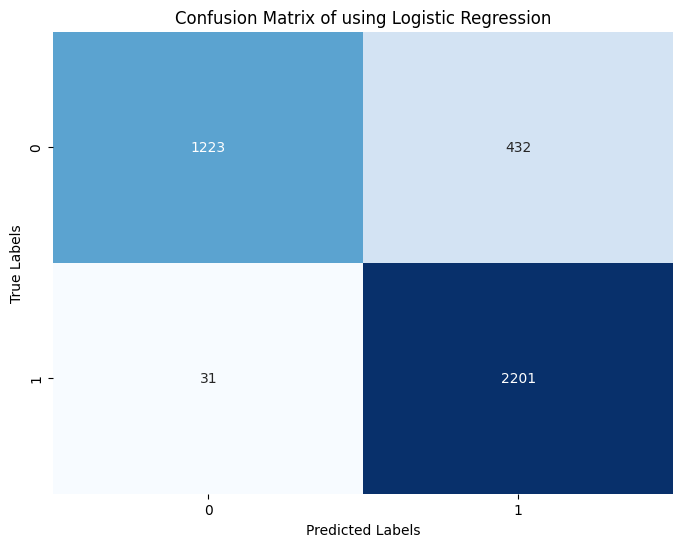

In [ ]:
# Huấn luyện mô hình Logistic Regression
clf_LR = LogisticRegression()
clf_LR.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_LR.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Sử dụng mô hình Gaussian Naive Bayes để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

              precision    recall  f1-score   support

           0       0.70      0.96      0.81      1655
           1       0.96      0.69      0.80      2232

    accuracy                           0.80      3887
   macro avg       0.83      0.82      0.80      3887
weighted avg       0.85      0.80      0.80      3887

F1-score of using Gaussian Naive Bayes: 0.8015645371577574


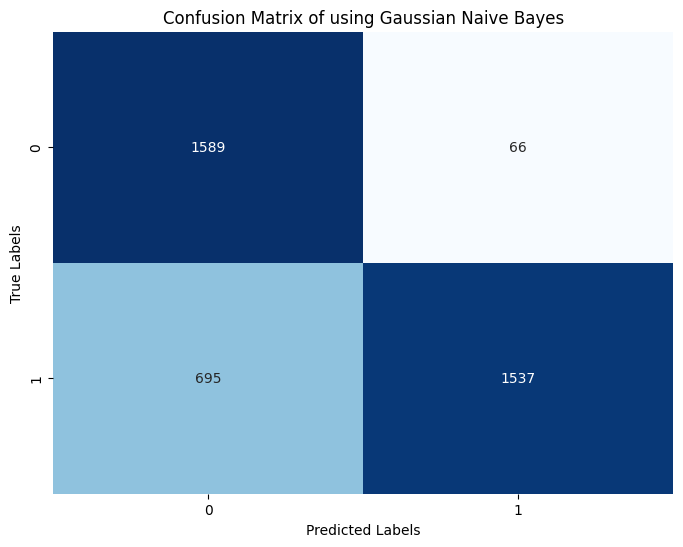

In [ ]:
# Huấn luyện mô hình Gaussian Naive Bayes
clf_NB = GaussianNB()
clf_NB.fit(X_train.toarray(), y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_NB.predict(X_test.toarray())

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Gaussian Naive Bayes:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Sử dụng mô hình Decision Tree Classifier để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

              precision    recall  f1-score   support

           0       0.94      0.77      0.85      1655
           1       0.85      0.96      0.90      2232

    accuracy                           0.88      3887
   macro avg       0.89      0.87      0.87      3887
weighted avg       0.89      0.88      0.88      3887

F1-score of using Decision Tree Classifier: 0.9025210084033614


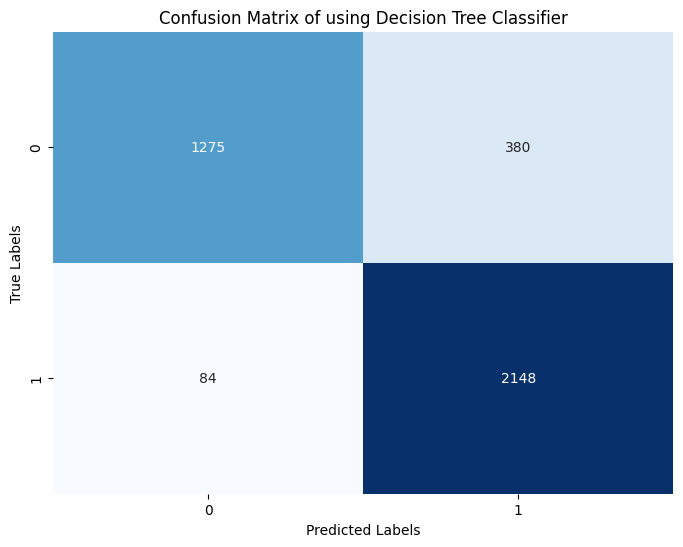

In [ ]:
# Huấn luyện mô hình Decision Tree Classifier
clf_Tree = DecisionTreeClassifier()
clf_Tree.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_Tree.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Decision Tree Classifier:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Decision Tree Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Trường hợp đặc biệt: Bỏ họ ra khỏi data, chỉ xét tên đệm và tên. Nếu Họ và tên chỉ có 2 từ thì ta chỉ xét tên.`
`Xoá họ ra khỏi data:`

In [ ]:
X_erase_surname = []
for line in data['full_name']:
  fname = line
  middle_name, name = separate_full_name(fname)
  if middle_name != "":
    X_erase_surname.append(middle_name + " " + name)
  else:
    X_erase_surname.append(name)
print(X_erase_surname)

['Thảo Vy', 'Thế Huy', 'Minh Long', 'Mai Khanh', 'Hồng Diệp', 'Ngọc Thái', 'Tường Vy', 'Trúc Quỳnh', 'Minh Đức', 'Ngọc Tấn', 'Minh Hiếu', 'Kim Yến', 'Thị Thanh', 'Lệ Chi', 'Tấn Nghĩa', 'Kim Dân', 'Minh Chương', 'Thị Việt', 'Xuân Việt', 'Nhật Huy', 'Đức Trung', 'Tiến Đạt', 'Ngọc Giàu', 'Mỹ Linh', 'Phúc', 'Yến Ngọc', 'Thị Trang', 'Hiếu Nhơn', 'Anh Hiếu', 'Thị Trang', 'Anh Duy', 'Thanh Ngôn', 'Thiện Huân', 'Đình Đức', 'Diệu Hiền', 'Đại Nghĩa', 'Thu Thủy', 'Khảo Xương', 'Anh Tú', 'Sec Váy', 'Huỳnh Duyên', 'Mỹ Uyên', 'Tiến Nam', 'Thanh Thanh', 'Thiên Phước', 'Xuân Tùng', 'Huy Phong', 'Như Minh', 'Thanh Quí', 'Quang Hào', 'Thành Đạt', 'Bích Trúc', 'Trung Dũng', 'Ngọc Công', 'Thị Triều', 'Mỹ Phương', 'Hoàng Anh', 'Thảo Nguyên', 'Huỳnh Như', 'Tuấn Sang', 'Thu Huyền', 'Kim Ngân', 'Hải Đăng', 'Trọng Khánh', 'Thanh Toàn', 'Nhựt Tân', 'Ái Liên', 'Kiều Diễm', 'Minh Thiên', 'Hồng Phi', 'Minh Thoại', 'Hải Thắng', 'Công Danh', 'Mạnh Hùng', 'Ngọc Thuận', 'Song Luân', 'Xuân Tuyền', 'Quý Tài', 'Khánh Ngọ

`Áp dụng các bước bag of n-grams đã trình bày ở phía trên, tổng hợp lại được đoạn code sau:`

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
cv = CountVectorizer(ngram_range=(2, 3))
X_convert = cv.fit_transform(np.array(X_train))
print(X_convert.toarray())
cv.get_feature_names_out()
X_train, X_test, y_train, y_test = train_test_split(X_convert, Y, test_size=0.2, random_state=42)

TypeError: ignored

`SVM`

In [ ]:
# Huấn luyện mô hình SVM
clf = SVC()
clf.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using SVM:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Logistic Regression`

In [ ]:
# Huấn luyện mô hình Logistic Regression
clf_LR = LogisticRegression()
clf_LR.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_LR.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Gaussian Naive Bayes`

In [ ]:
# Huấn luyện mô hình Gaussian Naive Bayes
clf_NB = GaussianNB()
clf_NB.fit(X_train.toarray(), y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_NB.predict(X_test.toarray())

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Gaussian Naive Bayes:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Decision Tree Classifier`

In [ ]:
# Huấn luyện mô hình Decision Tree Classifier
clf_Tree = DecisionTreeClassifier()
clf_Tree.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_Tree.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Decision Tree Classifier:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Decision Tree Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

####`3.3. TF-IDF`

`Trong thư viện sklearn.feature_extraction.text có một hàm là CountVectorizer(), ta dùng hàm này để áp dụng mô hình Bag of n-grams cho đồ án.`



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer()

In [ ]:
tf_v= tfidf.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tf_v, Y, test_size=0.2, random_state=42)

`Sử dụng mô hình SVM để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

In [ ]:
# Huấn luyện mô hình SVM
clf = SVC()
clf.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using SVM:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Sử dụng mô hình Logistic Regression để huấn luyện mô hình và đánh giá độ chính xác của mô hình`



In [ ]:
# Huấn luyện mô hình Logistic Regression
clf_LR = LogisticRegression()
clf_LR.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_LR.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Sử dụng mô hình Gaussian Naive Bayes để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

In [ ]:
# Huấn luyện mô hình Gaussian Naive Bayes
clf_NB = GaussianNB()
clf_NB.fit(X_train.toarray(), y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_NB.predict(X_test.toarray())

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Gaussian Naive Bayes:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Sử dụng mô hình Decision Tree Classifier để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

In [ ]:
# Huấn luyện mô hình Decision Tree Classifier
clf_Tree = DecisionTreeClassifier()
clf_Tree.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_Tree.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Decision Tree Classifier:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Decision Tree Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Trường hợp đặc biệt: Bỏ họ ra khỏi data, chỉ xét tên đệm và tên. Nếu Họ và tên chỉ có 2 từ thì ta chỉ xét tên.`
`Xoá họ ra khỏi data:`

In [ ]:
X_erase_surname = []
for line in data['full_name']:
  fname = line
  middle_name, name = separate_full_name(fname)
  if middle_name != "":
    X_erase_surname.append(middle_name + " " + name)
  else:
    X_erase_surname.append(name)
print(X_erase_surname)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
tfidf = TfidfVectorizer()
tf_v= tfidf.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(tf_v, Y, test_size=0.2, random_state=42)

`SVM`

In [ ]:
# Huấn luyện mô hình SVM
clf = SVC()
clf.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using SVM:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Logistic Regression`

In [ ]:
# Huấn luyện mô hình Logistic Regression
clf_LR = LogisticRegression()
clf_LR.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_LR.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Gaussian Naive Bayes`

In [ ]:
# Huấn luyện mô hình Gaussian Naive Bayes
clf_NB = GaussianNB()
clf_NB.fit(X_train.toarray(), y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_NB.predict(X_test.toarray())

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Gaussian Naive Bayes:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Decision Tree Classifier`

In [ ]:
# Huấn luyện mô hình Decision Tree Classifier
clf_Tree = DecisionTreeClassifier()
clf_Tree.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_Tree.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Decision Tree Classifier:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Decision Tree Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#### 3.4 Bag_of_words

In [ ]:
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
import pandas as pd
#df = pd.DataFrame(data)
df = pd.read_json("https://raw.githubusercontent.com/kiendoo4/final-project/main/dataset/Final_dataset.json")
print(df)

In [ ]:
X = df['full_name']
y = df['gender']

In [ ]:
processed_names = []
for name in X:
    # Tách từ và loại bỏ ký tự đặc biệt
    processed_name = ' '.join(word.lower() for word in name.split() if word.isalpha())
    processed_names.append(processed_name)

#Xây dựng từ điển từ các từ trong tên đầy đủ

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(processed_names)

In [ ]:
print("Vocabulary size: {}", format(len(vectorizer.vocabulary_)))
print("Vocabualry content:\n {}", format(vectorizer.vocabulary_))

#Chia bộ dữ liệu thành tập huấn luyện và tập kiểm tra

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Huấn luyện mô hình Logistic Regression

In [ ]:
# Huấn luyện mô hình Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
print(classification_report(y_test, y_pred))
print("F1-score of using logistic regression:", f1_score(y_test, y_pred))

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using logistic regression Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

##Huấn luyện mô hình SVM

In [ ]:
#2. Train a SVM classifier
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Predict on the test set
svm_pred = svm_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("F1-score of using SVM model:", f1_score(y_test, svm_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, svm_pred)

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, svm_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
#

#Huấn luyện mô hình Decision Tree

In [ ]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
dt_pred = tree_model.predict(X_test)

In [ ]:
print(classification_report(y_test, dt_pred))
print("F1-score of using Decision Tree:", f1_score(y_test, y_pred))

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Decisin Tree")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Huấn luyện mô hình Gaussian Naive Bayes

In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train.toarray(), y_train)
nb_pred = nb_model.predict(X_test.toarray())

In [ ]:
print(classification_report(y_test, y_pred))
print("F1-score of using Gaussian Naive Bayes :", f1_score(y_test, nb_pred))

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, nb_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#Tách họ ra khỏi họ và tên trong dataset, ta được kết quả như sau

In [ ]:
#Split function to take away the surname
def separate_full_name(full_name):
    fname = full_name.split()
    name = ""
    middle_name = ""
    surname = ""
    if len(fname) > 2:
      name = fname[len(fname) - 1]
      surname = fname[len(fname) - 3]
      middle_name = fname[len(fname) - 2]
    elif len(fname) == 2:
      name = fname[1]
      middle_name = ""
      surname = ""
    return middle_name, name

In [ ]:
X_erase_surname = []
for line in df['full_name']:
  fname = line
  middle_name, name = separate_full_name(fname)
  if middle_name != "":
    X_erase_surname.append(middle_name + " " + name)
  else:
    X_erase_surname.append(name)
print(X_erase_surname)

In [ ]:
y = df['gender']

In [ ]:
processed_names = []
for name in X_erase_surname:
    # Tách từ và loại bỏ ký tự đặc biệt
    processed_name = ' '.join(word.lower() for word in name.split() if word.isalpha())
    processed_names.append(processed_name)

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(processed_names)

In [ ]:
print("Vocabulary size: {}", format(len(vectorizer.vocabulary_)))
print("Vocabualry content:\n {}", format(vectorizer.vocabulary_))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Huấn luyện mô hình Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
print(classification_report(y_test, y_pred))
print("F1-score of using logistic regression:", f1_score(y_test, y_pred))

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using logistic regression Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#Huấn luyện mô hình SVM

In [ ]:
#2. Train a SVM classifier
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Predict on the test set
svm_pred = svm_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("F1-score of using SVM model:", f1_score(y_test, svm_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, svm_pred)

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, svm_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#Huấn luyện mô hình Decision Tree

In [ ]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
dt_pred = tree_model.predict(X_test)

In [ ]:
print(classification_report(y_test, dt_pred))
print("F1-score of using Decision Tree:", f1_score(y_test, y_pred))

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Decisin Tree")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#Huấn luyện mô hình Gaussian Naive Bayes

In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train.toarray(), y_train)
nb_pred = nb_model.predict(X_test.toarray())

In [ ]:
print(classification_report(y_test, y_pred))
print("F1-score of using Gaussian Naive Bayes :", f1_score(y_test, nb_pred))

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, nb_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

##**`IV. Kết luận`**
